## Pet Finder - Adopción de Mascotas



PetFinder.es una plataforma de adopción de Mascotas de Malasia, con una base de datos de más de 150.000 animales. 

Las tasas de adopción de animales están fuertemente correlacionadas con los metadatos asociados con sus perfiles en línea, como el texto descriptivo y las características de las fotografías. Como ejemplo, PetFinder está experimentando actualmente con una herramienta de inteligencia artificial simple llamada Cuteness Meter, que clasifica qué tan linda es una mascota en función de las cualidades presentes en sus fotos.

En esta competencia, desarrollará algoritmos para predecir la adoptabilidad de las mascotas, específicamente, ¿qué tan rápido se adopta una mascota?

Web Organización: https://www.petfinder.my/

Datos: https://www.kaggle.com/c/petfinder-adoption-prediction

## Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

## Análisis Exploratorio de Datos - Feature Engineering

In [6]:
import os

# Si estás en Jupyter Notebook, anclás a una ruta conocida o fija:
project_root = r"C:\Users\juanm\GitHub\UA_MDM_Labo2_G9"  

# Rutas de trabajo
workDir = os.path.join(project_root, "work")

# Cambiar al directorio de trabajo solo si es necesario
if os.getcwd() != workDir:
    os.chdir(workDir)

print("Directorio actual:", os.getcwd())


Directorio actual: C:\Users\juanm\GitHub\UA_MDM_Labo2_G9\work


In [7]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Modelado: Gradient Boosting
import lightgbm as lgb

# Sklearn: splits, métricas y utilidades
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Visualización
import matplotlib.pyplot as plt  # Usar junto con seaborn o plotly si es necesario
import plotly.express as px      # Corrección: no usar `from plotly import express as px`

# Optuna para optimización de hiperparámetros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

# Utilidades propias
from utiles import plot_confusion_matrix

# Guardado de objetos
from joblib import dump, load

# Sistema
import os

In [8]:
import os

# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Datos de razas 
PATH_TO_BREED_LABELS = os.path.join(BASE_DIR, "modelo/data/petfinder-adoption-prediction/BreedLabels.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

In [ ]:
import numpy as np
import pandas as pd

# Cargar el dataset
dataset = pd.read_csv(PATH_TO_TRAIN)

# 1. Tiene nombre
dataset['HasName'] = dataset['Name'].notnull().astype(int)

# 2. Es de raza pura
# Cargar etiquetas de razas
breed_labels = pd.read_csv(PATH_TO_BREED_LABELS)

# Diccionario ID → Nombre de raza
id_to_breed = dict(zip(breed_labels['BreedID'], breed_labels['BreedName']))

# Crear una nueva columna con el nombre de Breed1
dataset['Breed1_name'] = dataset['Breed1'].map(id_to_breed)

dataset['PureBreed'] = (
    (dataset['Breed2'] == 0) &
    (~dataset['Breed1_name'].str.contains('Mixed', case=False, na=False))
).astype(int)

# 3. Longitud de la descripción
dataset['DescLength'] = dataset['Description'].fillna('').apply(len)

# 4. Combinación tipo-raza principal
dataset['Type_Breed_Combo'] = dataset['Type'].astype(str) + '_' + dataset['Breed1'].astype(str)

dataset['Type_Breed_Combo'] = dataset['Type_Breed_Combo'].astype('category')

# 5. Tarifa por mascota
dataset['Fee_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['Fee'] / dataset['Quantity'])

# 6. Fotos por mascota
dataset['Photo_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['PhotoAmt'] / dataset['Quantity'])

# 7. Relación edad/tarifa
dataset['Age_Fee_Ratio'] = dataset['Age'] / (dataset['Fee'] + 1)

# 8. Longitud descripción por mascota
dataset['DescLength_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['DescLength'] / dataset['Quantity'])

# 9. Longitud descripción por cantidad de fotos 
dataset['DescLength_per_Photo'] = np.where(dataset['PhotoAmt'] == 0,0,dataset['DescLength'] / dataset['PhotoAmt'])

# 10. Tarifa promedio por raza
breed_fee_mean = dataset.groupby('Breed1')['Fee'].mean()

dataset['Fee_Breed_Ratio'] = dataset['Fee'] / (dataset['Breed1'].map(breed_fee_mean) + 1)


# Type



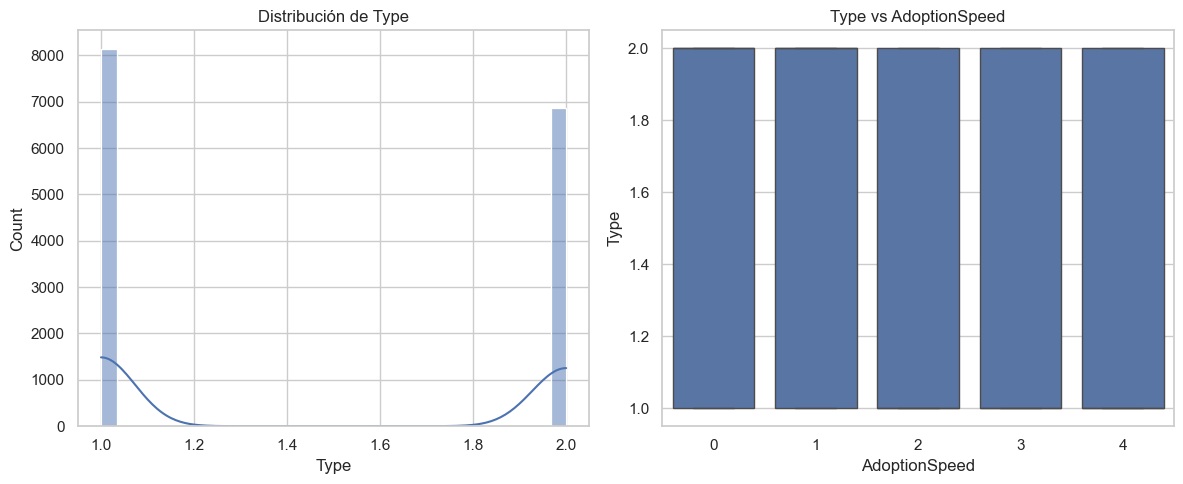

# Age



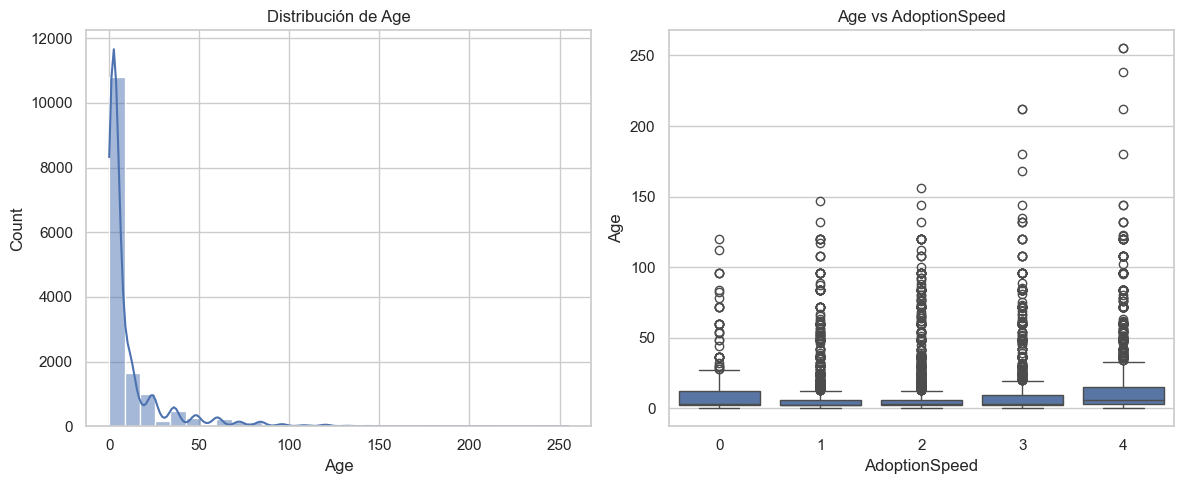

# Breed1



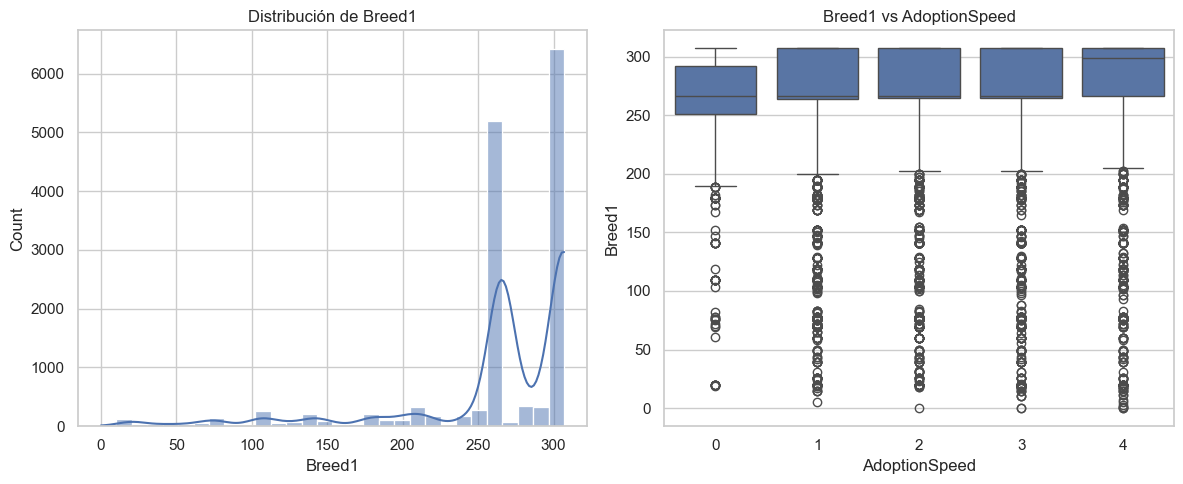

# Breed2



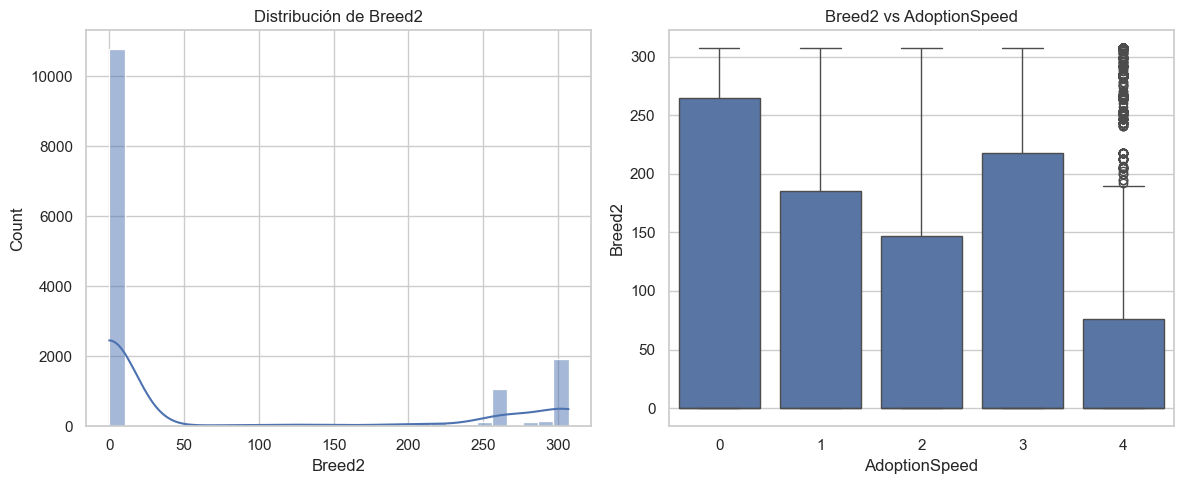

# Gender



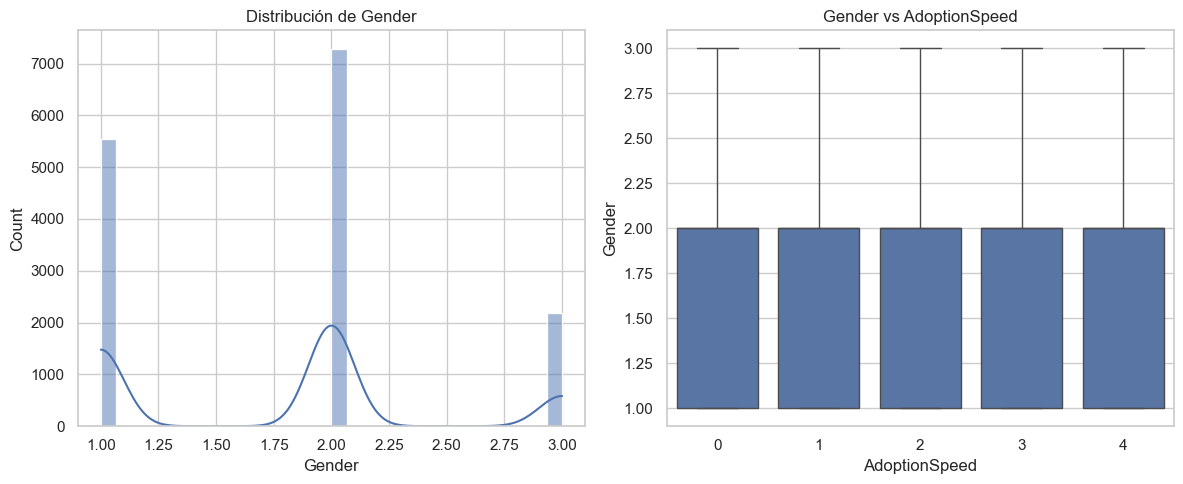

# Color1



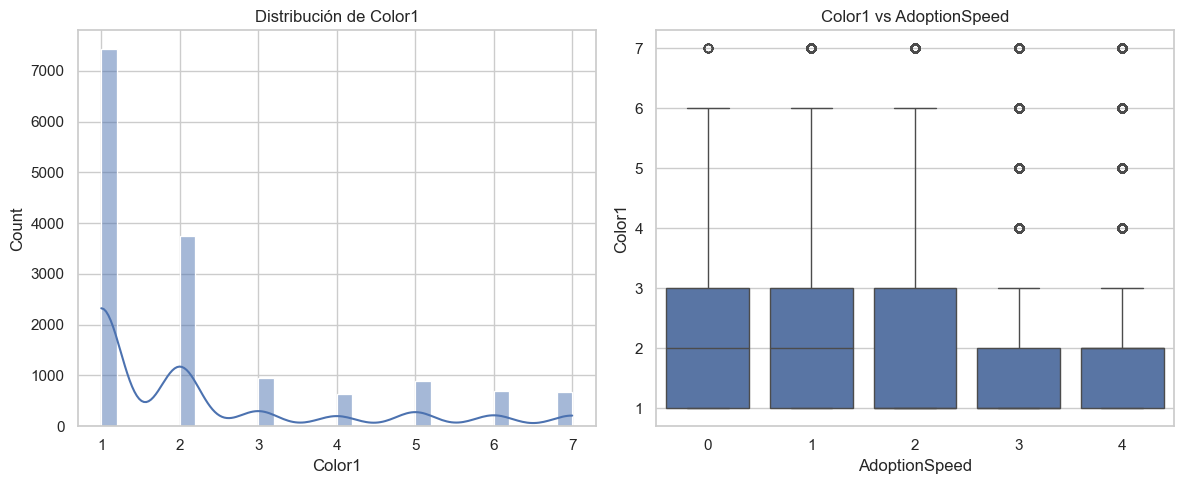

# Color2



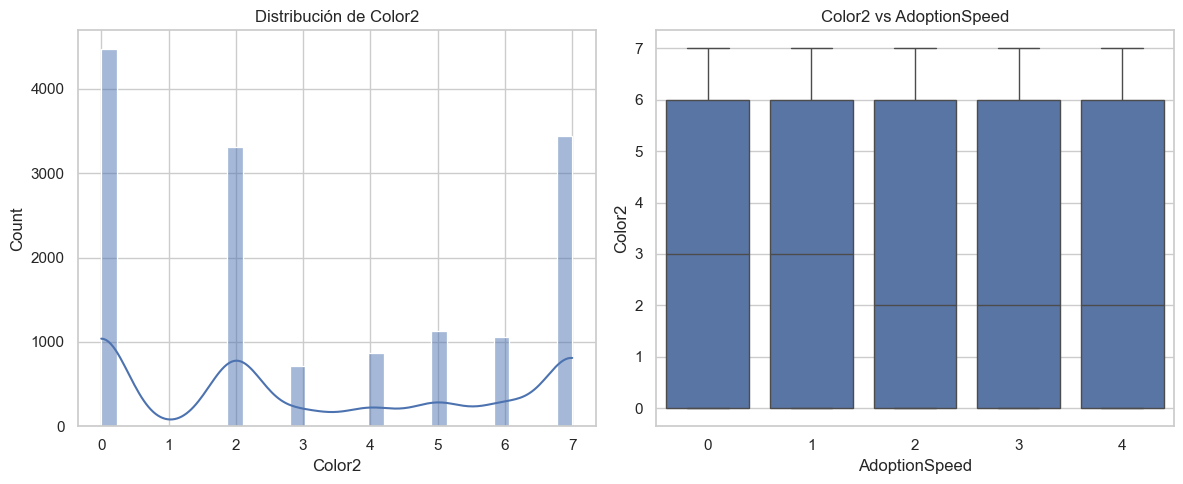

# Color3



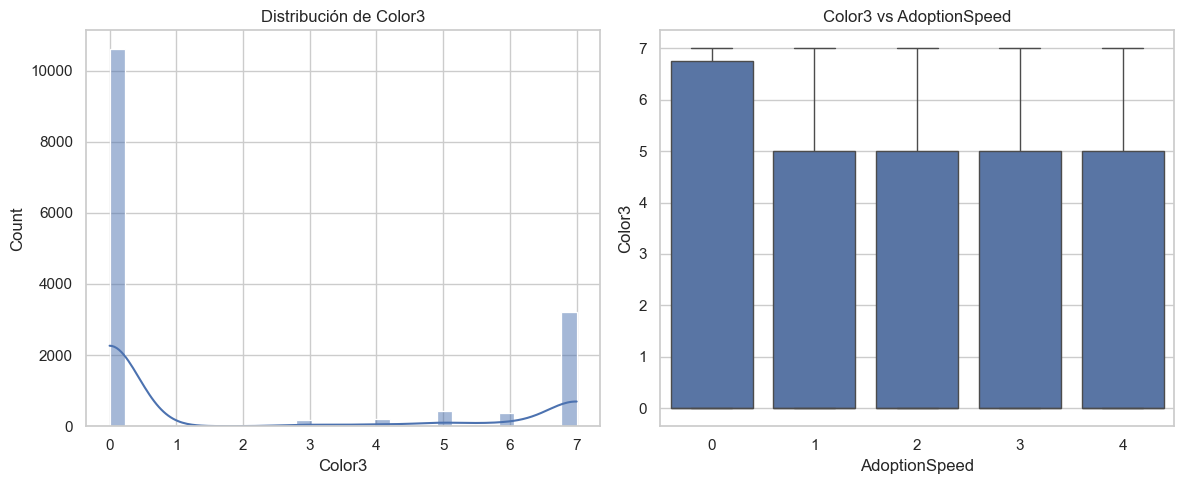

# MaturitySize



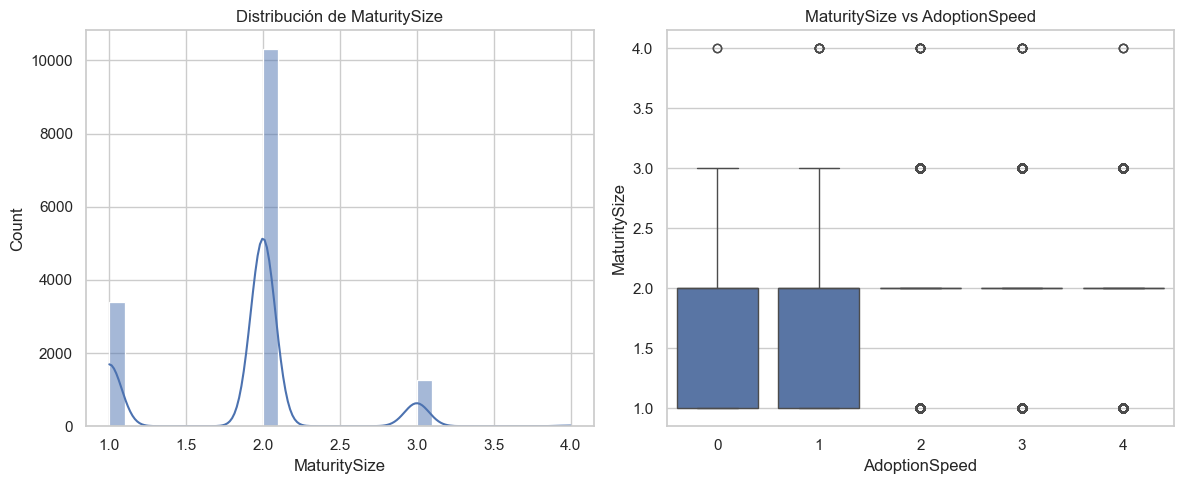

# FurLength



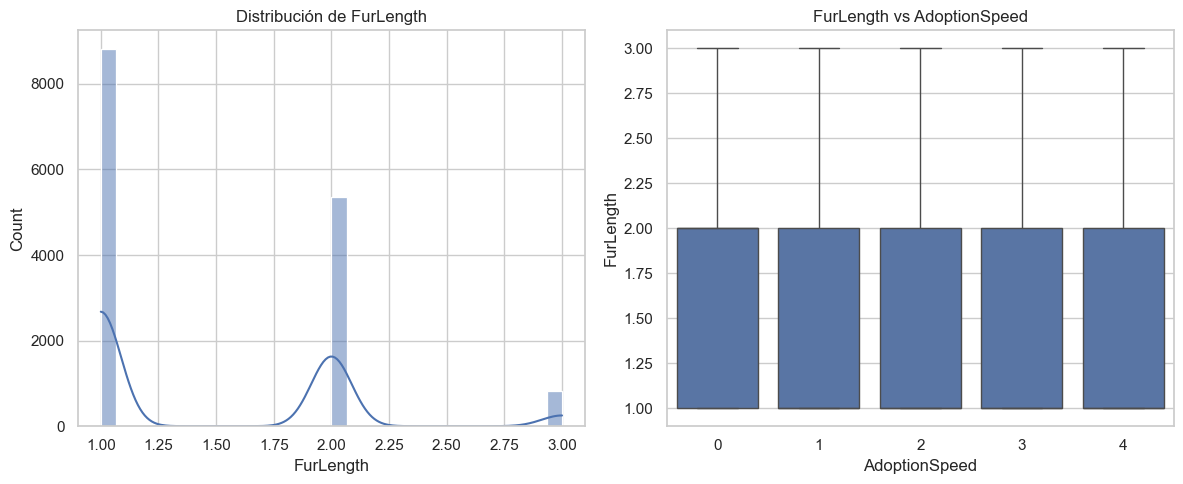

# Vaccinated



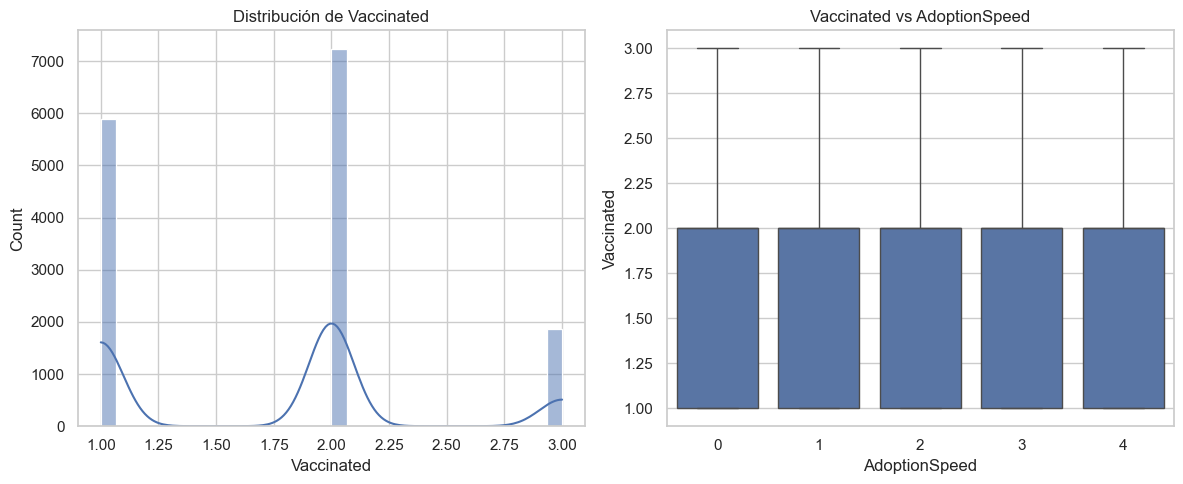

# Dewormed



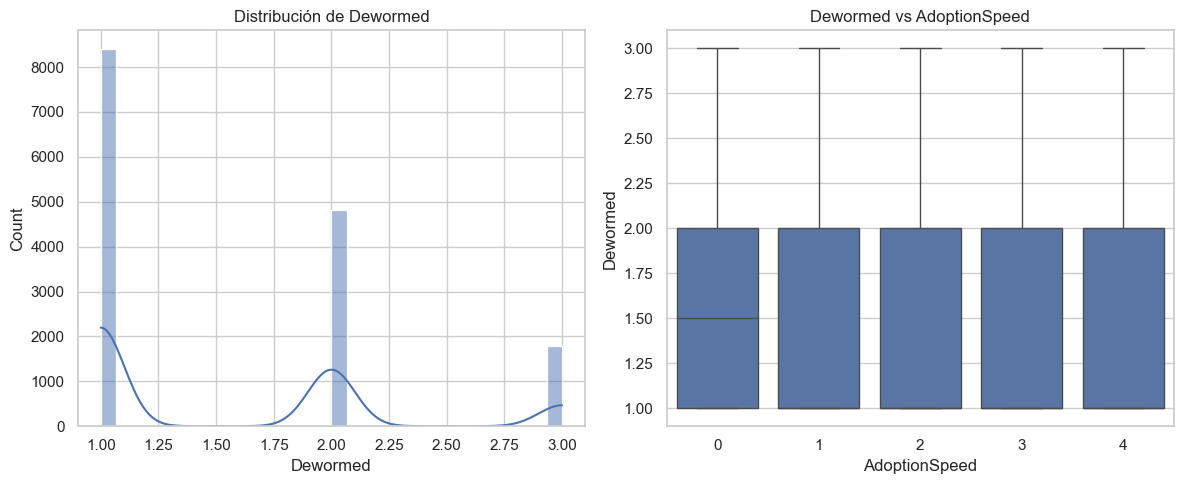

# Sterilized



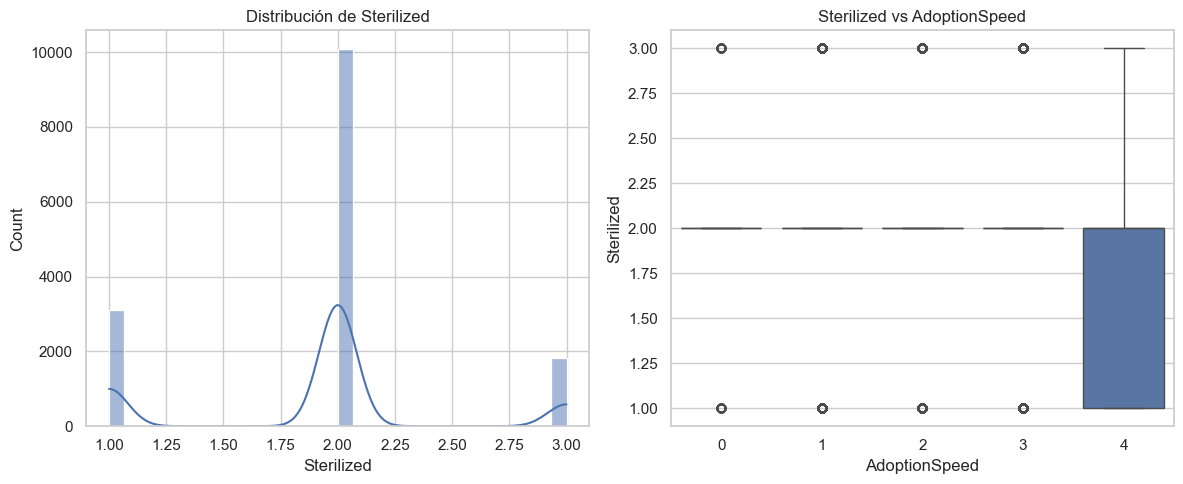

# Health



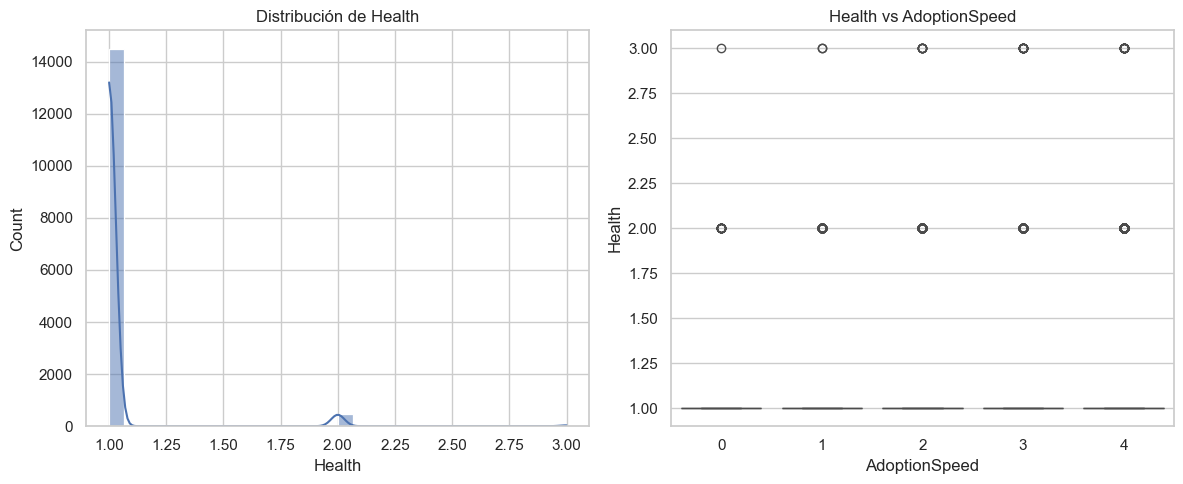

# Quantity



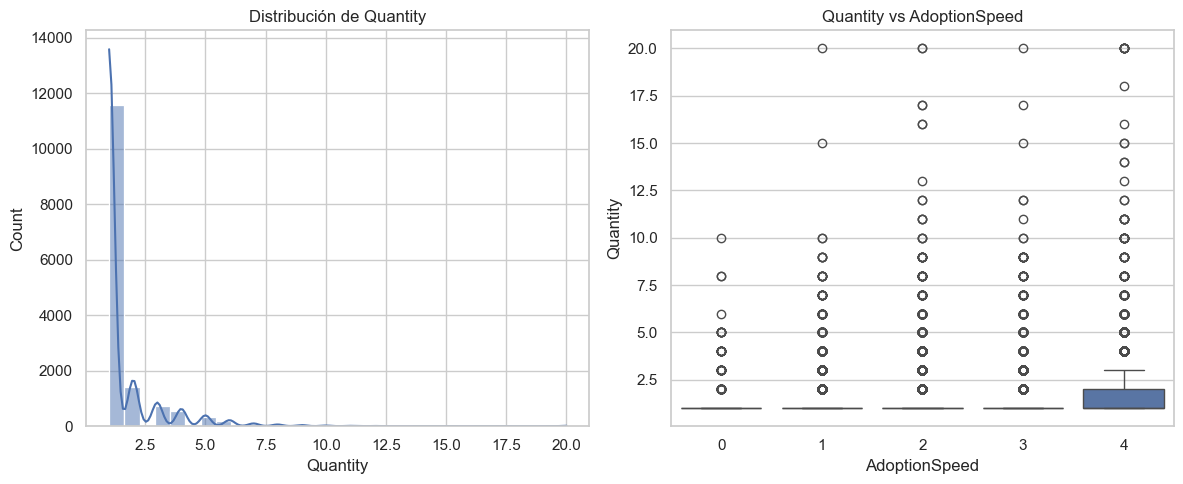

# Fee



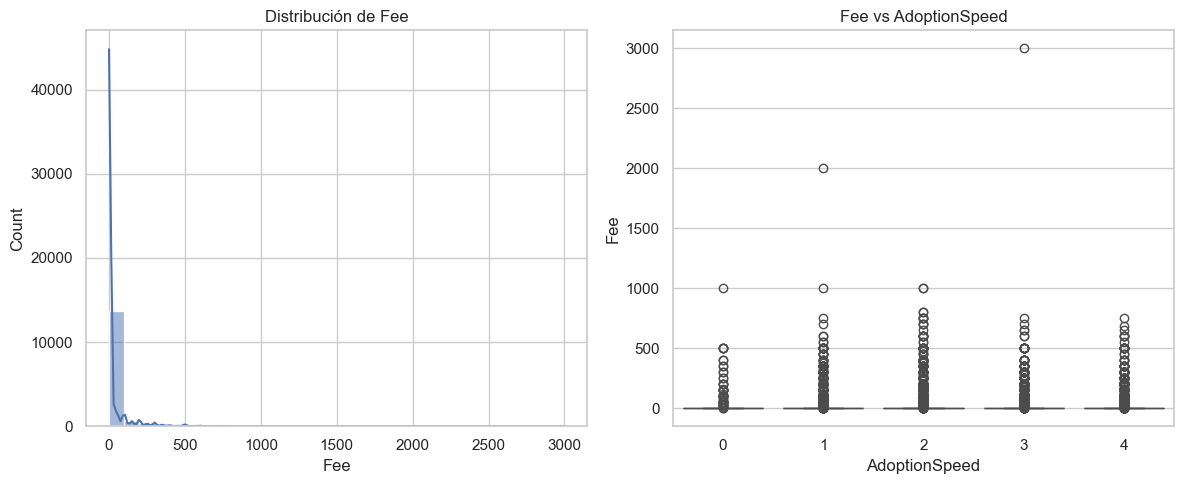

# State



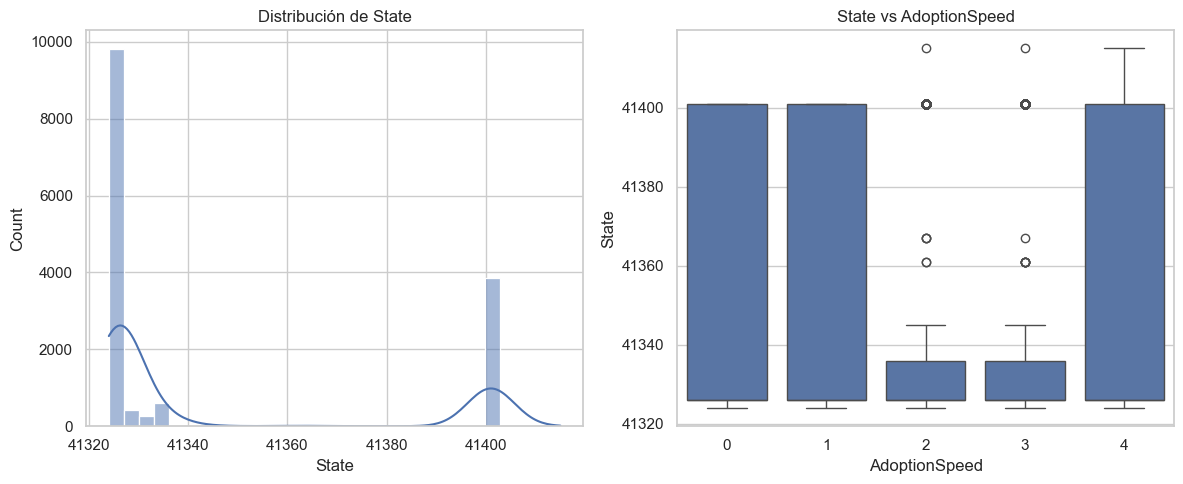

# VideoAmt



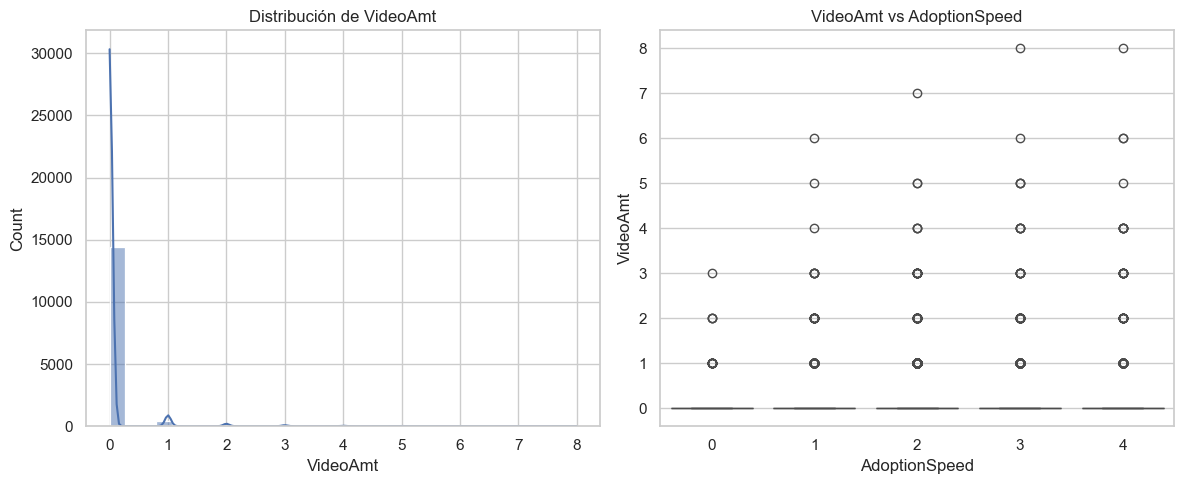

# PhotoAmt



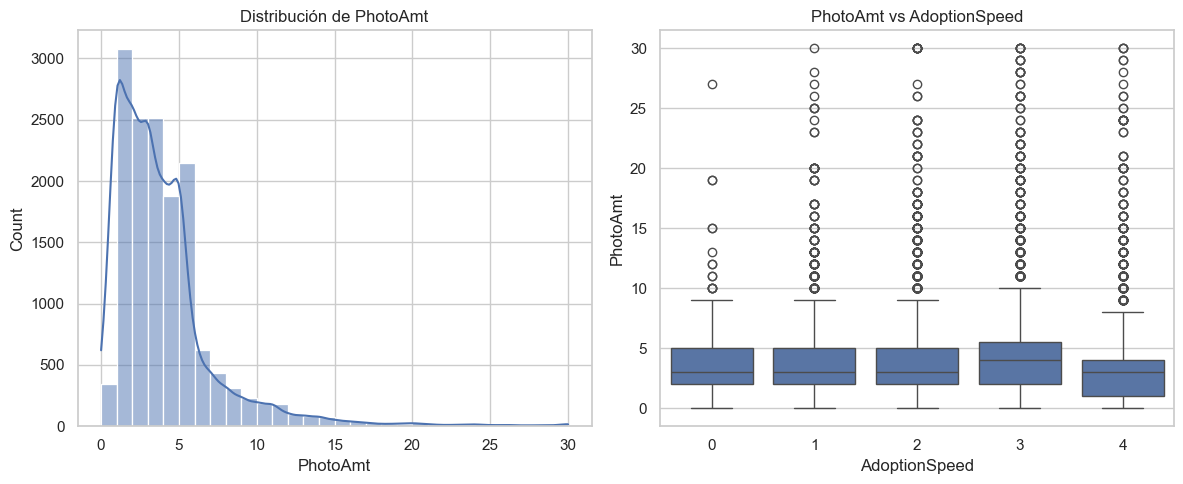

# AdoptionSpeed



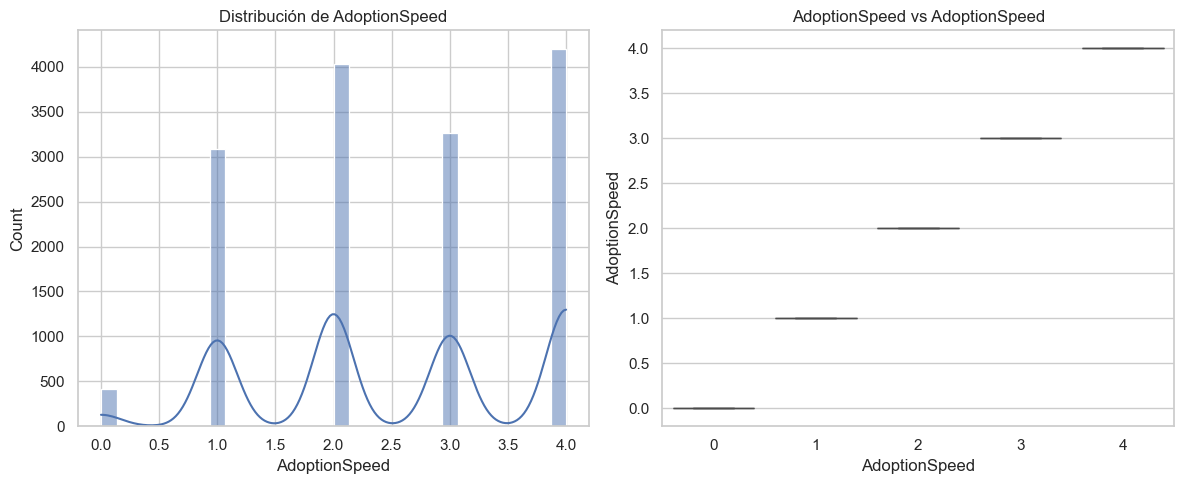

# HasName



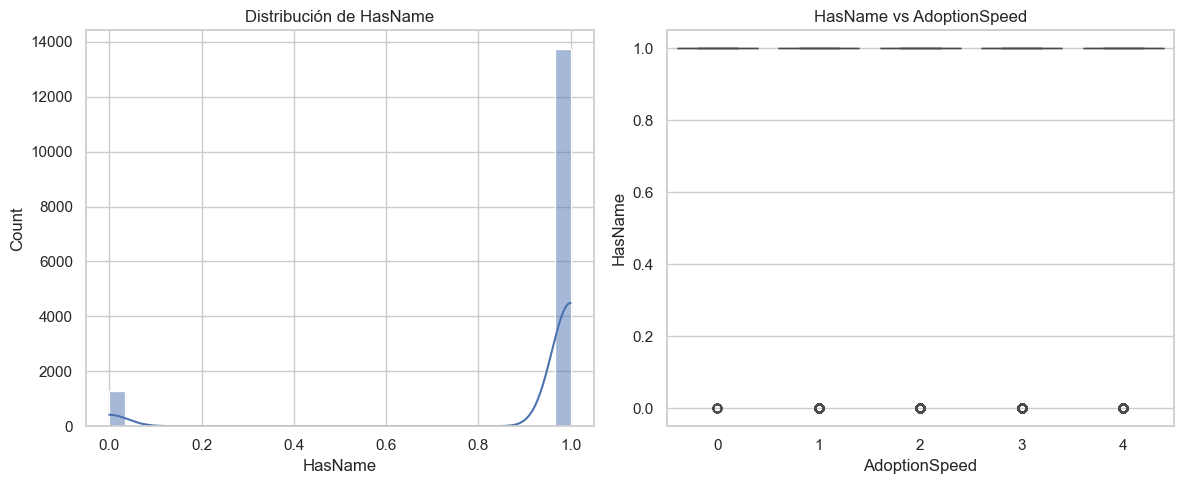

# PureBreed



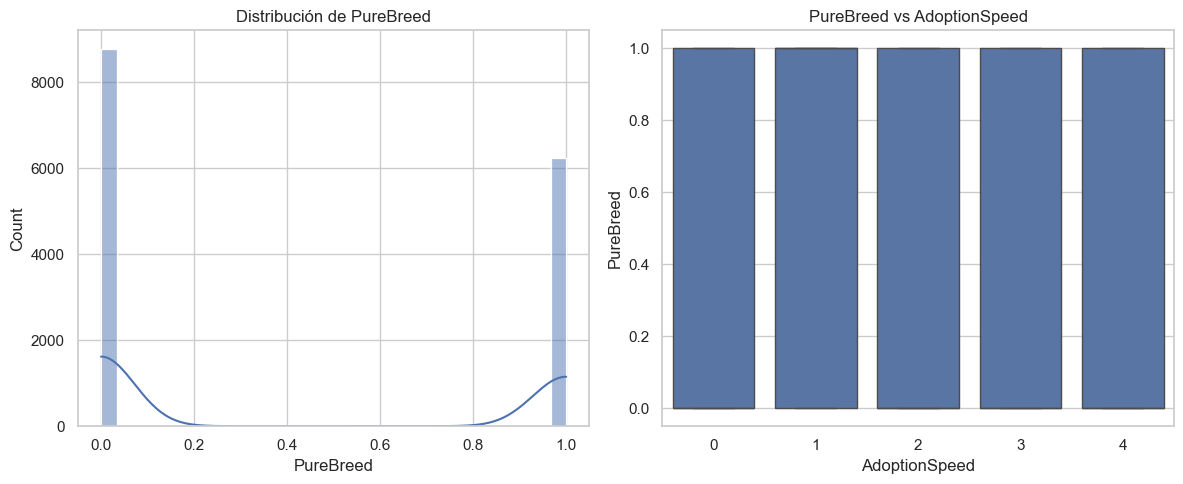

# DescLength



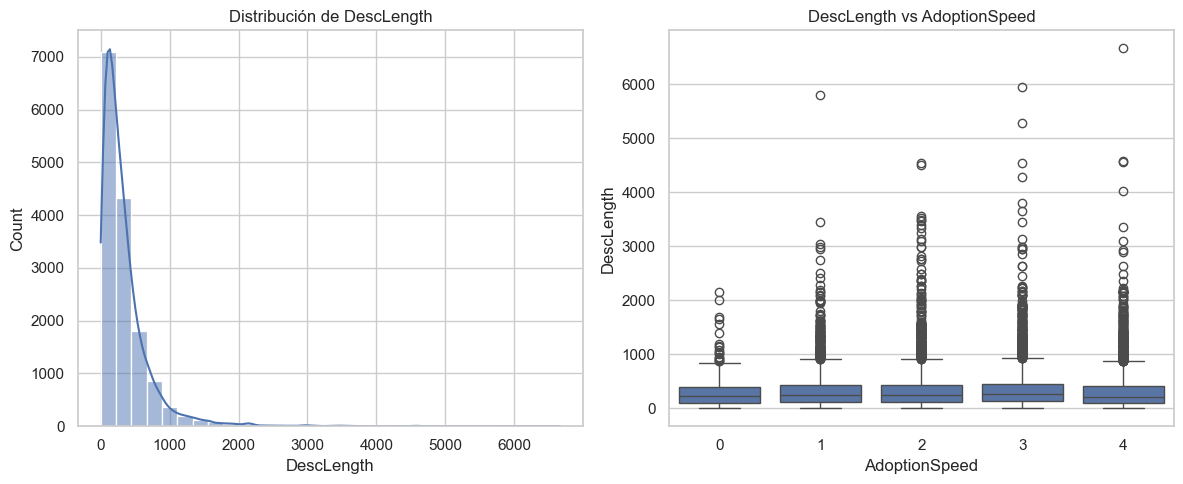

# Fee_per_Pet



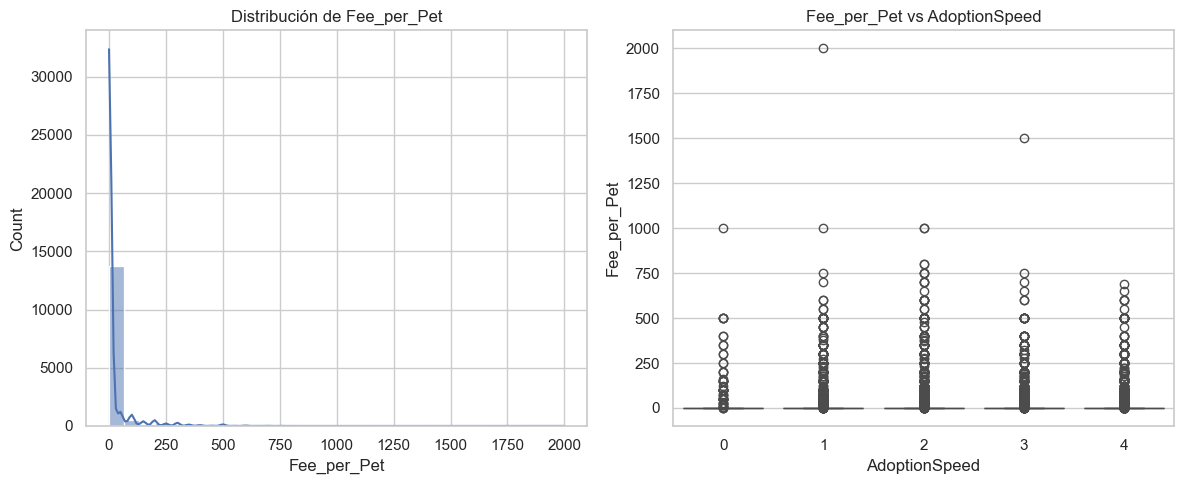

# Photo_per_Pet



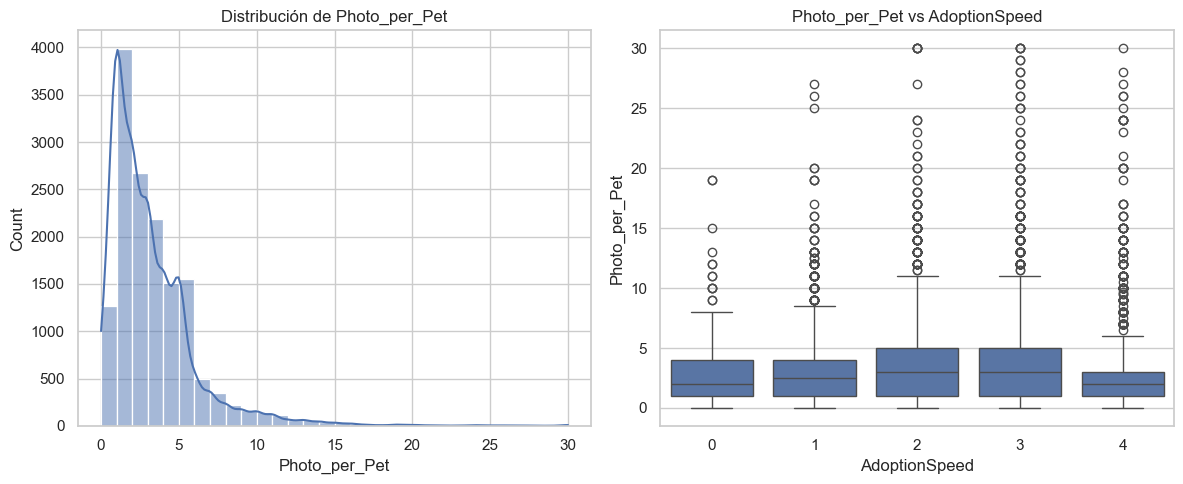

# Age_Fee_Ratio



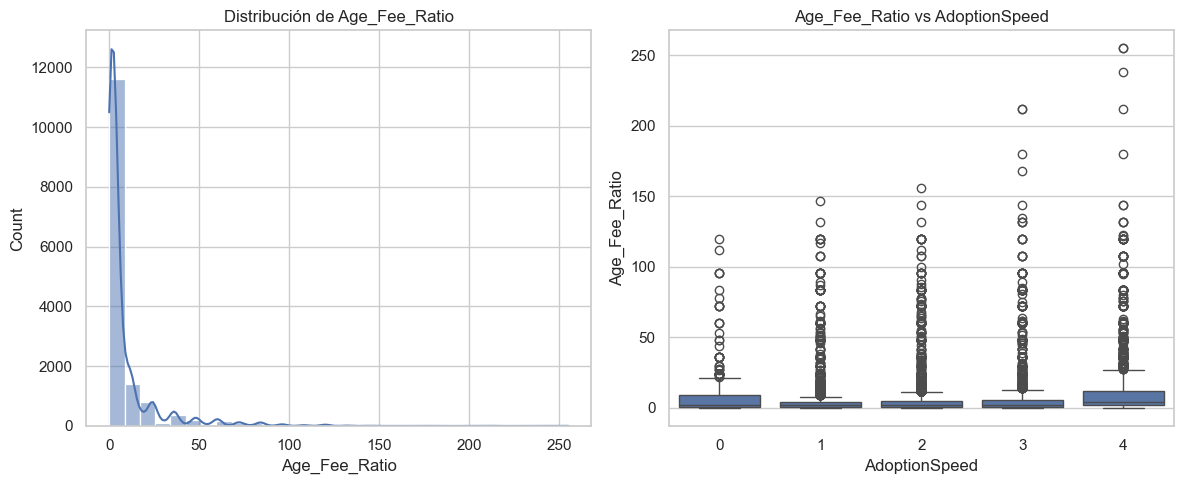

# DescLength_per_Pet



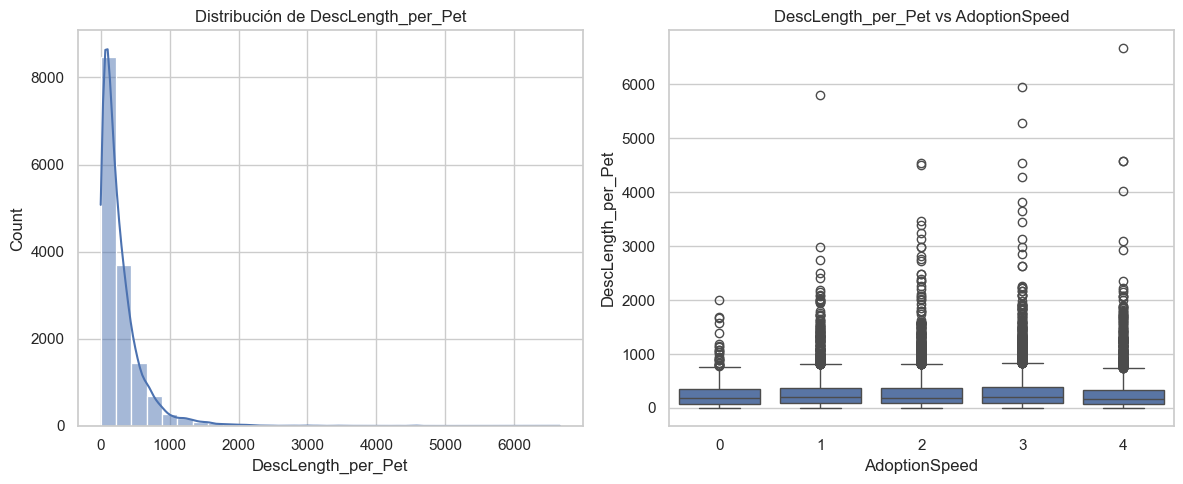

# DescLength_per_Photo



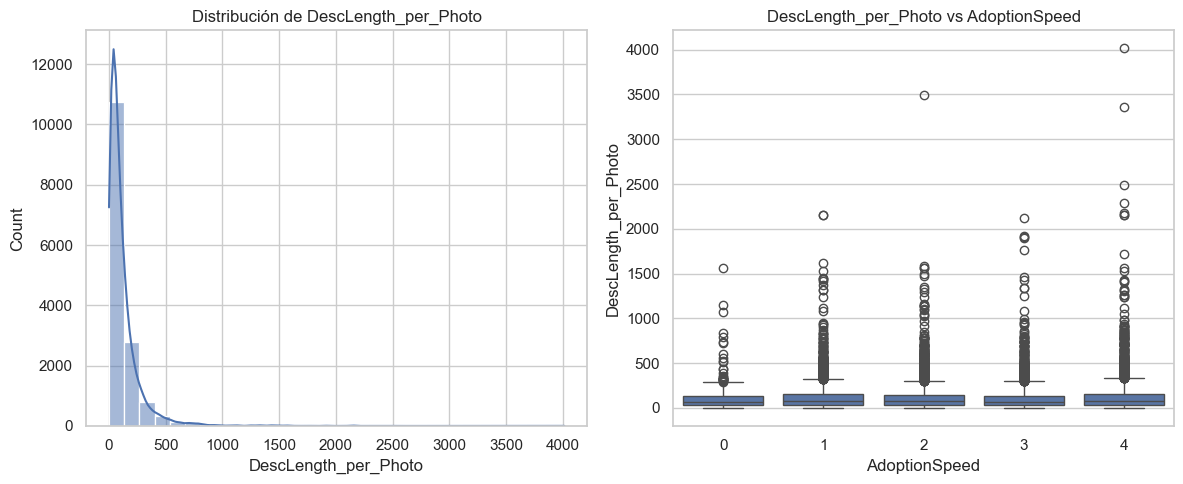

# Fee_Breed_Ratio



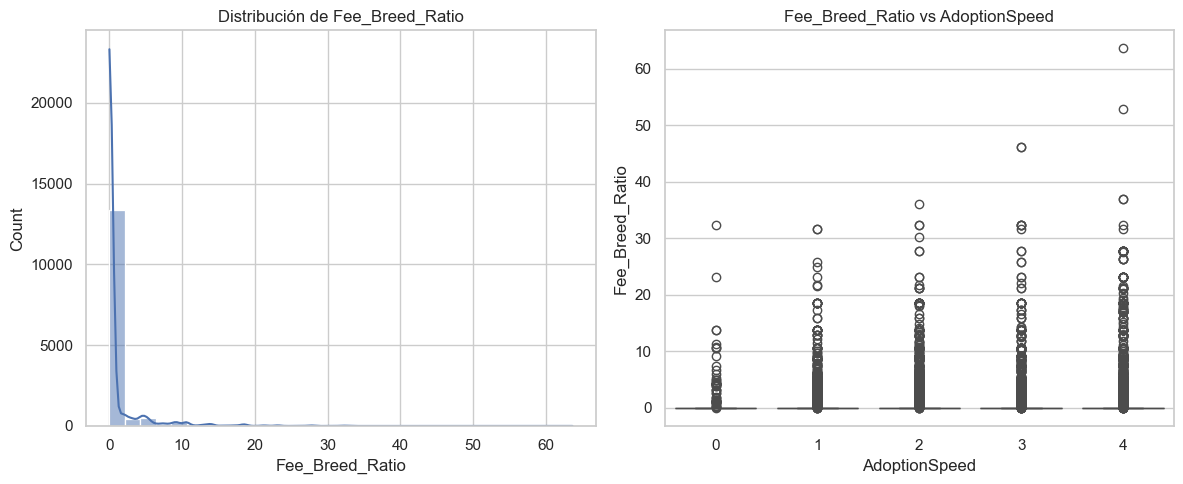



# Mapa de Calor de Correlaciones



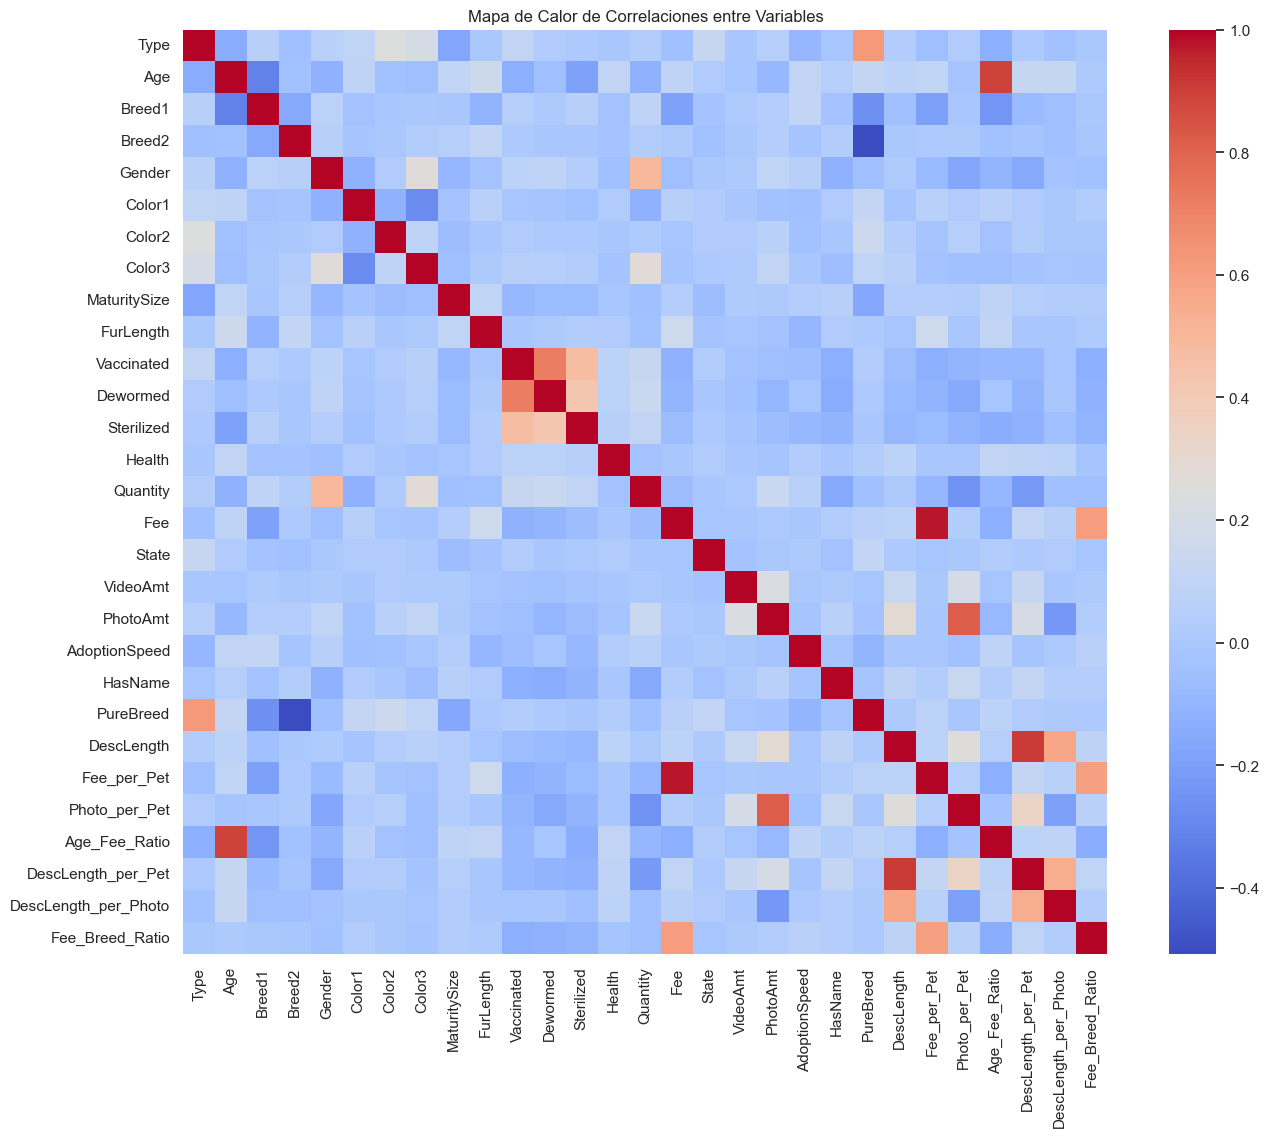

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

variables_num = []

# Asegurarnos de usar estilo agradable
sns.set_theme(style="whitegrid")

# 1. Definimos las variables numéricas reales
variables = [f for f in dataset.columns if pd.api.types.is_numeric_dtype(dataset[f])]

# 2. Funciones auxiliares

def plot_numeric(var):
    print(f"# {var}\n")
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(dataset[var].dropna(), kde=True, bins=30)
    plt.title(f"Distribuci\u00f3n de {var}")

    plt.subplot(1,2,2)
    sns.boxplot(x='AdoptionSpeed', y=var, data=dataset)
    plt.title(f"{var} vs AdoptionSpeed")
    plt.tight_layout()
    plt.show()


def plot_categorical(var):
    print(f"# {var}\n")
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.countplot(x=var, data=dataset, order=dataset[var].value_counts().index)
    plt.title(f"Distribuci\u00f3n de {var}")
    plt.xticks(rotation=45)

    plt.subplot(1,2,2)
    adoption_means = dataset.groupby(var)['AdoptionSpeed'].mean().sort_values()
    sns.barplot(x=adoption_means.index, y=adoption_means.values)
    plt.title(f"AdoptionSpeed promedio por {var}")
    plt.xticks(rotation=45)
    plt.ylabel("AdoptionSpeed promedio")
    plt.tight_layout()
    plt.show()

# 3. Loop general
for var in variables:
    if var in dataset.columns:
        if pd.api.types.is_numeric_dtype(dataset[var]):
            plot_numeric(var)
            variables_num.append(var)
        else:
            plot_categorical(var)
    else:
        print(f"Variable {var} no encontrada en el dataset.")

# 4. Mapa de calor de correlaciones
print("\n\n# Mapa de Calor de Correlaciones\n")
corr = dataset[variables_num].corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', square=True)
plt.title('Mapa de Calor de Correlaciones entre Variables')
plt.show()